<a href="https://colab.research.google.com/github/tlchen4/BDRADMiniProject/blob/master/BreastResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Breast ResNet BDRAD MiniProject



##Import Libraries and Data

Check versions

Mount google drive and load data

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import torch
import numpy as np
import os
from google.colab import drive


print(tf.__version__)
print(matplotlib.__version__)
print(torch.__version__)
print(np.__version__)

TensorFlow 2.x selected.
2.1.0-rc1
3.1.2
1.3.1
1.17.4


In [2]:
drive.mount('/gdrive')
%cd /gdrive

%cd "/gdrive/My Drive/BDRAD Breast MiniProject"
!dir

TrainingData = np.load("ResizedTrainingCompressed.npz", allow_pickle=True)
TestData = np.load("ResizedTestCompressed.npz", allow_pickle=True)

TrainingData['Master_Data'][0][1]
# size = torch.Size([2,2])
# x = torch.empty(size)
# print(x)
# print(size)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive
/gdrive/My Drive/BDRAD Breast MiniProject
ResizedTestCompressed.npz      SavedModels  test.png
ResizedTrainingCompressed.npz  test


array([[0.99998474, 0.99998474, 0.99998474, ..., 0.54456652, 0.54711881,
        0.54870736],
       [0.99998474, 0.99998474, 0.99998474, ..., 0.35103934, 0.35648413,
        0.35766997],
       [0.99998474, 0.99998474, 0.99996948, ..., 0.04019114, 0.04222347,
        0.04288102],
       ...,
       [0.99998474, 0.99998474, 0.99998474, ..., 0.26794384, 0.26814883,
        0.26841419],
       [0.99998474, 0.99998474, 0.99998474, ..., 0.33050694, 0.32900271,
        0.32913177],
       [0.99998474, 0.99998474, 0.99998474, ..., 0.4211159 , 0.42277043,
        0.4225252 ]])

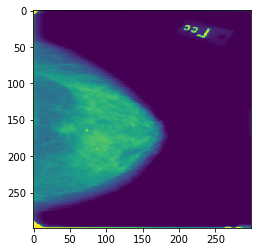

In [3]:
plt.imshow(TrainingData['Master_Data'][0][1])
plt.show()

#check to make sure imported data is what we wanted

These are the indices chosen (not patient ID) [20, 22, 43, 50, 121, 146, 168, 278, 323, 340]


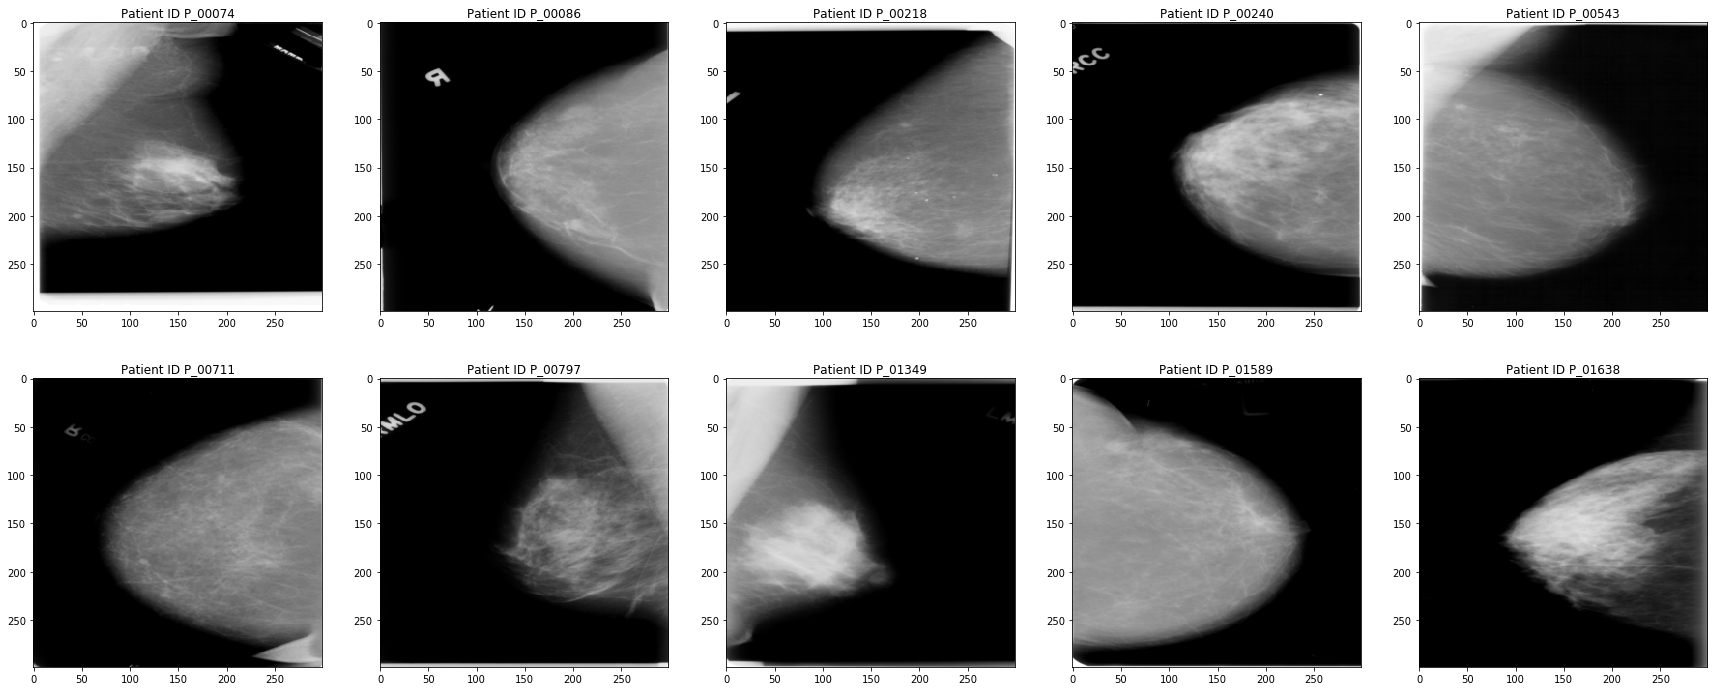

In [63]:
import random
# "random.sample takes a population and a sample size k and returns k random members of the population"

random.seed(215)
figBreasts, axes = plt.subplots(nrows=2, ncols=5)

figBreasts.set_figheight(12)
figBreasts.set_figwidth(30)
RandomImageIndex = random.sample(range(0,len(TrainingData['Master_Data'])),10)
RandomImageIndex.sort()
#randomly pick 10 numbers from 0 to length of list and then sort it
print("These are the indices chosen (not patient ID)", RandomImageIndex)

plt.figure(figBreasts.number)

for i in range(10):
    plt.subplot(2,5,i+1).set_title("Patient ID %s" %(TrainingData['Master_Data'][RandomImageIndex[i]][0]))
    plt.imshow(TrainingData['Master_Data'][RandomImageIndex[i]][1], cmap="gray")
        
plt.show()

##Build and Visualize the  Model

None in output shape refers to a variable dimension. First dimenion in keras models is always the batch size. None allows you to assign a variable batch size later on

In [17]:
#Build a ResNet - this will require keras functional API model
#Code based on: https://androidkt.com/resnet-implementation-in-tensorflow-keras/

def identity_block(x_input,input_filters,input_kernel):
  #identity block is a block in which shortcut path has no blocks in it
  #input_kernel size is for middle Conv2D only , the other 2 Conv2D will be 1x1 convolutions for filter dimension resizing
  x = tf.keras.layers.Conv2D(filters=input_filters[0],kernel_size=1,
                             kernel_initializer='he_normal')(x_input)
  x = tf.keras.layers.BatchNormalization(axis=-1)(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Conv2D(filters=input_filters[1],kernel_size=input_kernel,
                             kernel_initializer='he_normal', padding='same')(x)
  
  x = tf.keras.layers.BatchNormalization(axis=-1)(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Conv2D(filters=input_filters[2],kernel_size=1,
                             kernel_initializer='he_normal')(x)
  x = tf.keras.layers.BatchNormalization(axis=-1)(x)
  x = tf.keras.layers.add([x_input,x])
  x = tf.keras.layers.Activation('relu')(x)
  
  return x

def convolution_block(x_input,input_filters,input_kernel,stride=(1,1)):
  #convolution block is a block in which shortcut path has a convolution block in it

  #necessary when changing # of filters between blocks because the convolution block will change x_input out of previous
  #block to match the output filter dimension of 3rd conv (1x1) block in the main path - dimensions must match in order to add

  #input_kernel size is for middle (2nd) main path Conv2D only , the other 2 Conv2D will be 1x1 convolutions for filter dimension resizing
  #stride for main path non 1x1 convolution and shortcut convolution strides, set default at stride = 1
  x = tf.keras.layers.Conv2D(filters=input_filters[0],kernel_size=1,
                             kernel_initializer='he_normal')(x_input)
  x = tf.keras.layers.BatchNormalization(axis=-1)(x)
  x = tf.keras.layers.Activation('relu')(x)

  x = tf.keras.layers.Conv2D(filters=input_filters[1],kernel_size=input_kernel,strides=stride,
                             kernel_initializer='he_normal', padding='same')(x)
  x = tf.keras.layers.BatchNormalization(axis=-1)(x)
  x = tf.keras.layers.Activation('relu')(x)

  x = tf.keras.layers.Conv2D(filters=input_filters[2],kernel_size=1,
                             kernel_initializer='he_normal')(x)
  x = tf.keras.layers.BatchNormalization(axis=-1)(x)

  shortcut_path = tf.keras.layers.Conv2D(filters=input_filters[2], kernel_size=1, strides=stride,kernel_initializer='he_normal')(x_input)
  shortcut_path = tf.keras.layers.BatchNormalization(axis=-1)(shortcut_path)  

  x = tf.keras.layers.add([shortcut_path,x])
  #watchout of dimension mismatch in this .add step
  x = tf.keras.layers.Activation('relu')(x)
  return x
  
res_input=tf.keras.layers.Input(shape=(299,299,1))

#Convolution layer 1 with 7x7 filter, stride of (2,2)
x1 = tf.keras.layers.ZeroPadding2D(padding=(3,3))(res_input) #use zero padding to get desired output dimension shapes
x1 = tf.keras.layers.Conv2D(filters=64,kernel_size=(7,7),strides=2, padding='valid',kernel_initializer='he_normal')(x1)
x1 = tf.keras.layers.BatchNormalization(axis=-1)(x1)
#generally choose BatchNormalization axis to  normalize over the channel index (usually last index so -1 generally works)
x1 = tf.keras.layers.Activation('relu')(x1)
x1 = tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=(2,2))(x1)

x1 = convolution_block(x1,[64,64,256],3)
x1 = identity_block(x1,[64,64,256],3)
x1 = identity_block(x1,[64,64,256],3)

x1 = convolution_block(x1,[128,128,512],3,stride=(2,2))
x1 = identity_block(x1,[128,128,512],3)
x1 = identity_block(x1,[128,128,512],3)

x1 = convolution_block(x1,[256,256,1024],3,stride=(2,2))
x1 = identity_block(x1,[256,256,1024],3)
x1 = identity_block(x1,[256,256,1024],3)

x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)
#average all pixels in each filter
dense_prediction=tf.keras.layers.Dense(2,activation='softmax')(x1)
ResNetModel = tf.keras.models.Model(inputs=res_input,outputs=dense_prediction)

ResNetModel.summary()




Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 299, 299, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 305, 305, 1)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_100 (Conv2D)             (None, 150, 150, 64) 3200        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
batch_normalization_102 (BatchN (None, 150, 150, 64) 256         conv2d_100[0][0]                 
____________________________________________________________________________________________

In [18]:
#Build a comparison network - based on LeNet/AlexNet

CNNModel = tf.keras.models.Sequential()
CNNModel.add(tf.keras.layers.Conv2D(filters=64,kernel_size = (3,3),strides=1,padding="same",input_shape=[299,299,1]))
CNNModel.add(tf.keras.layers.BatchNormalization(axis=-1))
CNNModel.add(tf.keras.layers.Activation('relu'))
CNNModel.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

CNNModel.add(tf.keras.layers.Conv2D(filters=64,kernel_size = (3,3),strides=1,padding="same",input_shape=[299,299,1]))
CNNModel.add(tf.keras.layers.BatchNormalization(axis=-1))
CNNModel.add(tf.keras.layers.Activation('relu'))
CNNModel.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

CNNModel.add(tf.keras.layers.Conv2D(filters=64,kernel_size = (3,3),strides=1,padding="same",input_shape=[299,299,1]))
CNNModel.add(tf.keras.layers.BatchNormalization(axis=-1))
CNNModel.add(tf.keras.layers.Activation('relu'))
CNNModel.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

CNNModel.add(tf.keras.layers.Conv2D(filters=64,kernel_size = (3,3),strides=1,padding="same",input_shape=[299,299,1]))
CNNModel.add(tf.keras.layers.BatchNormalization(axis=-1))
CNNModel.add(tf.keras.layers.Activation('relu'))
CNNModel.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

CNNModel.add(tf.keras.layers.Conv2D(filters=128,kernel_size = (3,3),strides=1,padding="same",input_shape=[299,299,1]))
CNNModel.add(tf.keras.layers.BatchNormalization(axis=-1))
CNNModel.add(tf.keras.layers.Activation('relu'))
CNNModel.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

CNNModel.add(tf.keras.layers.Conv2D(filters=128,kernel_size = (3,3),strides=1,padding="same",input_shape=[299,299,1]))
CNNModel.add(tf.keras.layers.BatchNormalization(axis=-1))
CNNModel.add(tf.keras.layers.Activation('relu'))
CNNModel.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
#flatten into vector to feed into dense/fully connected network that ends in a softmax layer for classification
CNNModel.add(tf.keras.layers.Flatten())

CNNModel.add(tf.keras.layers.Dense(64))
CNNModel.add(tf.keras.layers.BatchNormalization(axis=-1))
CNNModel.add(tf.keras.layers.Activation('relu'))

CNNModel.add(tf.keras.layers.Dense(64))
CNNModel.add(tf.keras.layers.BatchNormalization(axis=-1))
CNNModel.add(tf.keras.layers.Activation('relu'))

CNNModel.add(tf.keras.layers.Dense(2,activation='softmax'))
CNNModel.summary()




#My First network
# CNNModel = tf.keras.models.Sequential()
# CNNModel.add(tf.keras.layers.Conv2D(filters=16,kernel_size = (3,3),strides=1,padding="same",activation = 'relu',input_shape=[299,299,1]))
# CNNModel.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
# CNNModel.add(tf.keras.layers.Conv2D(filters=32,kernel_size = (3,3),strides=1,padding="same",activation = 'relu'))
# CNNModel.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
# CNNModel.add(tf.keras.layers.Conv2D(filters=32,kernel_size = (3,3),strides=1,padding="valid",activation = 'relu'))
# CNNModel.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
# CNNModel.add(tf.keras.layers.Conv2D(filters=32,kernel_size = (3,3),strides=1,padding="valid",activation = 'relu'))
# CNNModel.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
# CNNModel.add(tf.keras.layers.Conv2D(filters=64,kernel_size = (3,3),strides=1,padding="valid",activation = 'relu'))
# CNNModel.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
# #flatten into vector to feed into dense/fully connected network that ends in a softmax layer for classification
# CNNModel.add(tf.keras.layers.Flatten())
# CNNModel.add(tf.keras.layers.Dense(64,activation='relu'))
# CNNModel.add(tf.keras.layers.Dense(64,activation='relu'))
# CNNModel.add(tf.keras.layers.Dense(16,activation='relu'))
# CNNModel.add(tf.keras.layers.Dense(2,activation='softmax'))
# CNNModel.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_131 (Conv2D)          (None, 299, 299, 64)      640       
_________________________________________________________________
batch_normalization_133 (Bat (None, 299, 299, 64)      256       
_________________________________________________________________
activation_121 (Activation)  (None, 299, 299, 64)      0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 149, 149, 64)      36928     
_________________________________________________________________
batch_normalization_134 (Bat (None, 149, 149, 64)      256       
_________________________________________________________________
activation_122 (Activation)  (None, 149, 149, 64)     

**Visualize the models**

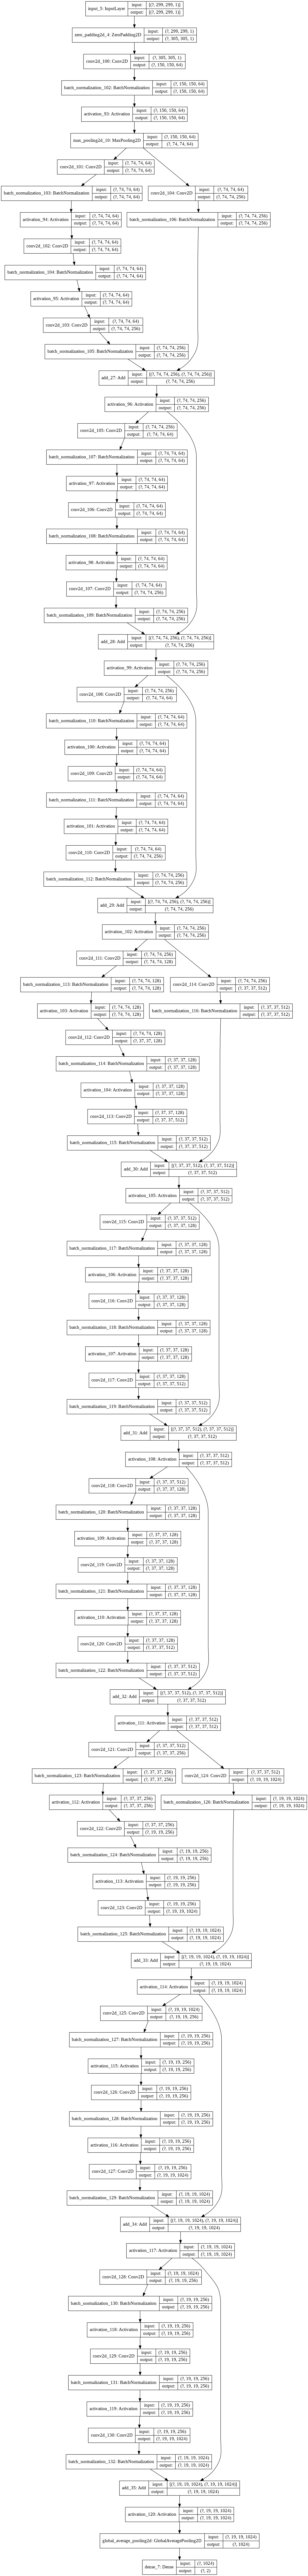

In [19]:
tf.keras.utils.plot_model(ResNetModel,'ResNet.png',show_shapes=True)

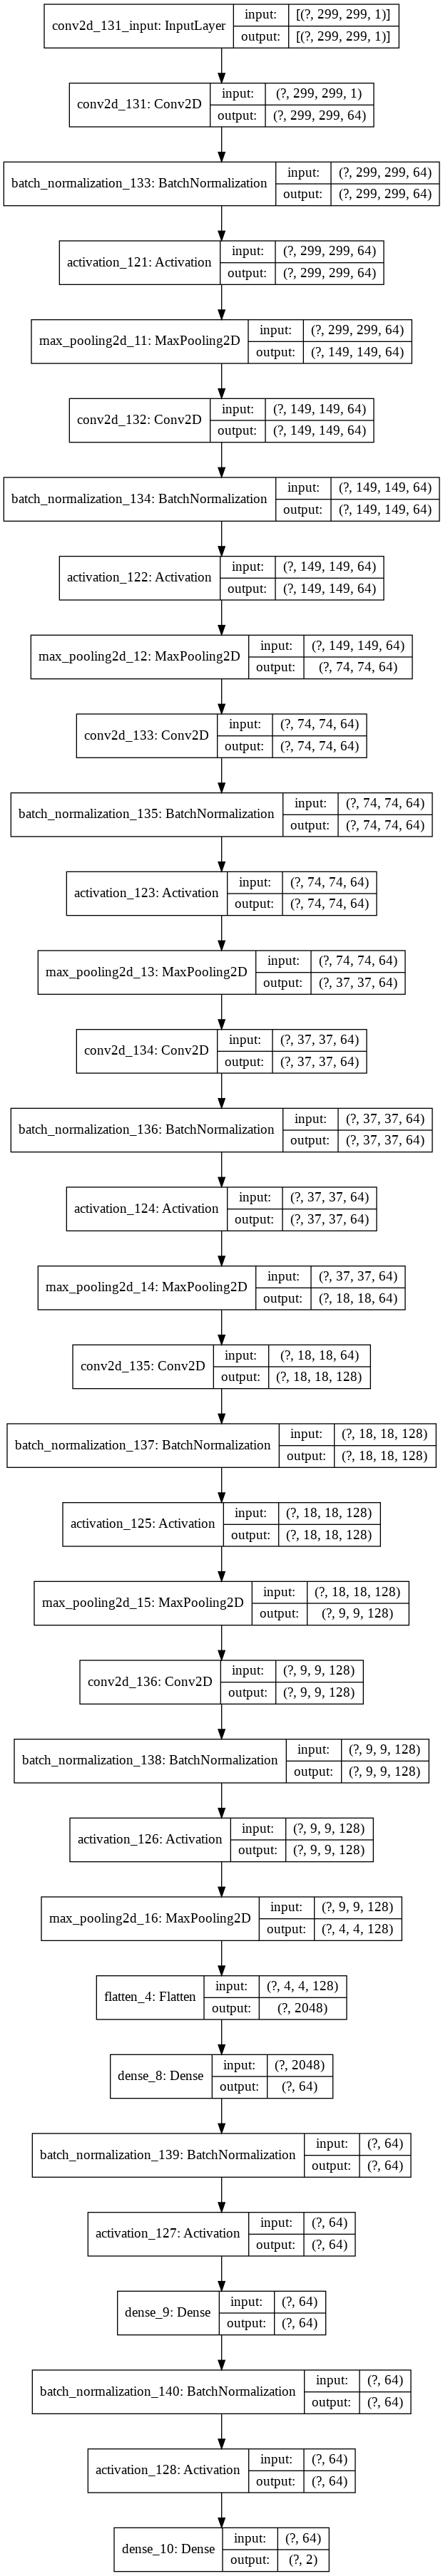

In [20]:
tf.keras.utils.plot_model(CNNModel,'CNN.png',show_shapes=True)


##Compile Model

In [0]:
CNNModel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#adam seems to perform better than rmsprop so far..

ResNetModel.compile(optimizer ='adam',loss='binary_crossentropy',metrics=['accuracy'])

##Train Model

In [0]:
Input_Data=[]
Input_Labels=[]

#Separate out the image data and labels data into separate lists from imported TrainingData
for i in TrainingData['Master_Data']:
  Input_Data.append(i[1])
  Input_Labels.append(i[2])

#Split Data and Label lists into a training and validation sets
#First 100 are validation, remaining 300 are training
Input_Train_Data = Input_Data[100:]
Input_Validation_Data = Input_Data[0:100]

Input_Train_Labels = Input_Labels[100:]
Input_Validation_Labels = Input_Labels[0:100]

#Our CNNModel requires a third dimension to data, so just extend 2D vector to 3D vector of size 1 in 3rd dimension
#Convert list to numpy array then reshape
TrainDataReshaped = np.reshape(np.asarray(Input_Train_Data), (len(np.asarray(Input_Train_Data)),299,299,1))
ValidationDataReshaped=np.reshape(np.asarray(Input_Validation_Data), (len(np.asarray(Input_Validation_Data)),299,299,1))

#Repeat above for TestData but no need to split a separate validation set
Test_Data=[]
Test_Labels=[]
for i in TestData['Master_Data']:
  Test_Data.append(i[1])
  Test_Labels.append(i[2])

TestDataReshaped = np.reshape(np.asarray(Test_Data), (len(np.asarray(Test_Data)),299,299,1))

#Need to convert label data from 1D to 2D for 2-class input

def ConvertLabelsBinaryClass(LabelVector):
  #Converts 1D 0 or 1 to to 2D [1 0] (not dense) or [0 1] (dense) respectively
  BinaryLabels=np.empty((len(LabelVector),2))
  for i in range(len(LabelVector)):
    if LabelVector[i] == 0:
      BinaryLabels[i] = [1,0]
    else:
      BinaryLabels[i] = [0,1]
  return BinaryLabels

TrainLabelsReshaped = ConvertLabelsBinaryClass(Input_Train_Labels)
ValidationLabelsReshaped=ConvertLabelsBinaryClass(Input_Validation_Labels)
TestLabelsReshaped = ConvertLabelsBinaryClass(Test_Labels)


In [24]:
#Train ResNet
savefilepath="./SavedModels/ResNet/"+"ResNetModel-Epoch{epoch}-ValLoss{val_loss:.4f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(savefilepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
checkpoint_list=[checkpoint]

train_history_res = ResNetModel.fit(TrainDataReshaped,TrainLabelsReshaped,batch_size=60,epochs=10,initial_epoch=0,callbacks=checkpoint_list,
                             validation_data=(ValidationDataReshaped,ValidationLabelsReshaped))

Train on 300 samples, validate on 100 samples
Epoch 1/10
240/300 [=======================>......] - ETA: 39s - loss: 0.9807 - accuracy: 0.5625 
Epoch 00001: val_loss improved from inf to 9.81574, saving model to ./SavedModels/ResNet/ResNetModel-Epoch1-ValLoss9.8157.hdf5
300/300 [==============================] - 210s 701ms/sample - loss: 0.9227 - accuracy: 0.5900 - val_loss: 9.8157 - val_accuracy: 0.3600
Epoch 2/10
240/300 [=======================>......] - ETA: 38s - loss: 0.5693 - accuracy: 0.7333 
Epoch 00002: val_loss did not improve from 9.81574
300/300 [==============================] - 204s 678ms/sample - loss: 0.5730 - accuracy: 0.7367 - val_loss: 9.8157 - val_accuracy: 0.3600
Epoch 3/10
240/300 [=======================>......] - ETA: 38s - loss: 0.5374 - accuracy: 0.7458 
Epoch 00003: val_loss did not improve from 9.81574
300/300 [==============================] - 203s 675ms/sample - loss: 0.5060 - accuracy: 0.7667 - val_loss: 9.8157 - val_accuracy: 0.3600
Epoch 4/10
240/300 [

In [23]:
#Train Comparison Net (CNN)

savefilepath="./SavedModels/CNNModel/"+"CNNModel-Epoch{epoch}-ValLoss{val_loss:.4f}.hdf5"
#save models under cwd/SavedModels, only save models that improve validation loss (minimize)
#include Epoch and val_loss in file name to 4 decimal floats  
#See also: https://machinelearningmastery.com/check-point-deep-learning-models-keras/

checkpoint = tf.keras.callbacks.ModelCheckpoint(savefilepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
checkpoint_list=[checkpoint]

#use fit method to train model
#fit(x,y,epochs=,batch_size=,validation_data=(x',y'))
#x is a vector, matrix or array of training data
#y is a vector, matrix, or array of labels/target output
#batch_size is 32 if unspecified

train_history_CNN = CNNModel.fit(TrainDataReshaped,TrainLabelsReshaped,batch_size=60,epochs=10,initial_epoch=0,callbacks=checkpoint_list,
                             validation_data=(ValidationDataReshaped,ValidationLabelsReshaped))
#initial_epoch is useful for continuing a previous training run that was interrupted

Train on 300 samples, validate on 100 samples
Epoch 1/10
240/300 [=======================>......] - ETA: 17s - loss: 0.7649 - accuracy: 0.5667
Epoch 00001: val_loss improved from inf to 0.67935, saving model to ./SavedModels/CNNModel/CNNModel-Epoch1-ValLoss0.6794.hdf5
300/300 [==============================] - 92s 306ms/sample - loss: 0.7294 - accuracy: 0.5867 - val_loss: 0.6794 - val_accuracy: 0.6400
Epoch 2/10
240/300 [=======================>......] - ETA: 16s - loss: 0.4452 - accuracy: 0.7958
Epoch 00002: val_loss improved from 0.67935 to 0.65961, saving model to ./SavedModels/CNNModel/CNNModel-Epoch2-ValLoss0.6596.hdf5
300/300 [==============================] - 90s 299ms/sample - loss: 0.4421 - accuracy: 0.8067 - val_loss: 0.6596 - val_accuracy: 0.6400
Epoch 3/10
240/300 [=======================>......] - ETA: 16s - loss: 0.3096 - accuracy: 0.8875
Epoch 00003: val_loss improved from 0.65961 to 0.65145, saving model to ./SavedModels/CNNModel/CNNModel-Epoch3-ValLoss0.6514.hdf5
300/3

##Evaluate Model

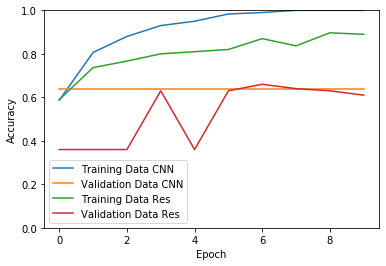

In [39]:
#model.evaluate(x,y) will return a loss and metric values for model on test set data x with labels y

#Visualize training accuracy vs epochs

AccuracyEpochFig = plt.figure(1)
Axes1=AccuracyEpochFig.gca()
Axes1.set_xlabel('Epoch')
Axes1.set_ylabel('Accuracy')
Axes1.set_ylim([0,1])

plt.figure(1)
plt.plot(train_history_CNN.history['accuracy'], label='Training Data CNN')
plt.plot(train_history_CNN.history['val_accuracy'], label='Validation Data CNN')
plt.plot(train_history_res.history['accuracy'], label='Training Data Res')
plt.plot(train_history_res.history['val_accuracy'], label='Validation Data Res')
Axes1.legend(loc='best')
plt.show()




In [40]:
test_loss_CNN, test_acc_CNN = CNNModel.evaluate(TestDataReshaped,TestLabelsReshaped, verbose = 1)
#verbose 0 = silent, 1 = progress bar
test_loss_res, test_acc_res = ResNetModel.evaluate(TestDataReshaped,TestLabelsReshaped, verbose = 1)

115/115 [==============================] - 14s 125ms/sample - loss: 3.1191 - accuracy: 0.5826


In [41]:
import sklearn.metrics as metrics
#import sklearn does not automatically import subpackages

testpredict_CNN=CNNModel.predict(TestDataReshaped)
#softmax output adds up to 1 for each sample across the columns of classes, interpret as a probability.

FPR_CNN,TPR_CNN,Thresholds_CNN = metrics.roc_curve(TestLabelsReshaped[:,1],testpredict_CNN[:,1])
#input to roc_curve requires labels and predict be 1D and be the "positive" tests (Dense breast in this project)
#label of 1 is set to be the positive label as default
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html

for i in range(len(TPR_CNN)):
  print("FPR: %f TPR: %f Threshold: %f \n" %(FPR_CNN[i],TPR_CNN[i],Thresholds_CNN[i]))
#visualize associated threshold for each FPR,TPR pairing


FPR: 0.000000 TPR: 0.000000 Threshold: 1.363674 

FPR: 0.016667 TPR: 0.000000 Threshold: 0.363674 

FPR: 0.033333 TPR: 0.000000 Threshold: 0.363450 

FPR: 0.033333 TPR: 0.072727 Threshold: 0.359718 

FPR: 0.050000 TPR: 0.072727 Threshold: 0.359574 

FPR: 0.050000 TPR: 0.090909 Threshold: 0.359254 

FPR: 0.083333 TPR: 0.090909 Threshold: 0.359001 

FPR: 0.083333 TPR: 0.145455 Threshold: 0.358575 

FPR: 0.100000 TPR: 0.145455 Threshold: 0.358508 

FPR: 0.100000 TPR: 0.163636 Threshold: 0.358204 

FPR: 0.116667 TPR: 0.163636 Threshold: 0.357614 

FPR: 0.116667 TPR: 0.200000 Threshold: 0.357438 

FPR: 0.133333 TPR: 0.200000 Threshold: 0.357258 

FPR: 0.133333 TPR: 0.218182 Threshold: 0.357137 

FPR: 0.150000 TPR: 0.218182 Threshold: 0.357120 

FPR: 0.150000 TPR: 0.254545 Threshold: 0.356889 

FPR: 0.200000 TPR: 0.254545 Threshold: 0.356660 

FPR: 0.200000 TPR: 0.309091 Threshold: 0.356443 

FPR: 0.216667 TPR: 0.309091 Threshold: 0.356352 

FPR: 0.216667 TPR: 0.345455 Threshold: 0.356277 



In [42]:
testpredict_res=ResNetModel.predict(TestDataReshaped)
#softmax output adds up to 1 for each sample across the columns of classes, interpret as a probability.


FPR_res,TPR_res,Thresholds_res = metrics.roc_curve(TestLabelsReshaped[:,1],testpredict_res[:,1])
#input to roc_curve requires labels and predict be 1D and be the "positive" tests (Dense breast in this project)
#label of 1 is set to be the positive label as default
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html

for i in range(len(TPR_res)):
  print("FPR: %f TPR: %f Threshold: %f \n" %(FPR_res[i],TPR_res[i],Thresholds_res[i]))
#visualize associated threshold for each FPR,TPR pairing

FPR: 0.000000 TPR: 0.000000 Threshold: 1.999999 

FPR: 0.016667 TPR: 0.000000 Threshold: 0.999999 

FPR: 0.016667 TPR: 0.072727 Threshold: 0.999798 

FPR: 0.050000 TPR: 0.072727 Threshold: 0.999153 

FPR: 0.050000 TPR: 0.109091 Threshold: 0.997474 

FPR: 0.083333 TPR: 0.109091 Threshold: 0.996348 

FPR: 0.083333 TPR: 0.163636 Threshold: 0.993173 

FPR: 0.100000 TPR: 0.163636 Threshold: 0.992906 

FPR: 0.100000 TPR: 0.272727 Threshold: 0.973873 

FPR: 0.116667 TPR: 0.272727 Threshold: 0.973729 

FPR: 0.116667 TPR: 0.290909 Threshold: 0.970050 

FPR: 0.166667 TPR: 0.290909 Threshold: 0.957915 

FPR: 0.166667 TPR: 0.309091 Threshold: 0.923823 

FPR: 0.183333 TPR: 0.309091 Threshold: 0.903709 

FPR: 0.183333 TPR: 0.345455 Threshold: 0.858122 

FPR: 0.200000 TPR: 0.345455 Threshold: 0.850977 

FPR: 0.200000 TPR: 0.363636 Threshold: 0.804868 

FPR: 0.250000 TPR: 0.363636 Threshold: 0.441237 

FPR: 0.250000 TPR: 0.381818 Threshold: 0.412647 

FPR: 0.300000 TPR: 0.381818 Threshold: 0.294605 



In [0]:
GuessPredict = [1 for i in range(len(TestLabelsReshaped))]

FPR_guess,TPR_guess,Thresholds_guess = sk.metrics.roc_curve(TestLabelsReshaped[:,1],GuessPredict)
#Create a control "Model" that always returns positive

##Confusion Matrix and Receiver Operating Curve (ROC)

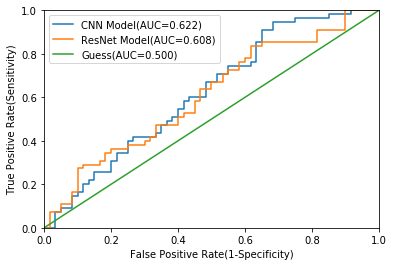

In [43]:
ROCFig = plt.figure(2)
Axes2=ROCFig.gca()
Axes2.set_xlabel('False Positive Rate(1-Specificity)')
Axes2.set_ylabel('True Positive Rate(Sensitivity)')
Axes2.set_xlim([0,1])
Axes2.set_ylim([0,1])

AUC_CNN=metrics.auc(FPR_CNN,TPR_CNN)
AUC_res=metrics.auc(FPR_res,TPR_res)
AUC_guess=sk.metrics.auc(FPR_guess,TPR_guess)
#alternatively for finding AUC one can use sk.metrics.roc_auc_score which takes input of TrueLabels,PredictedLabels
#AUCTEST = sk.metrics.roc_auc_score(TestLabelsReshaped[:,1],GuessPredict) 
#print("AUC of model is %.3f" %(AUCTEST))

plt.figure(2)
plt.plot(FPR_CNN,TPR_CNN, label='CNN Model(AUC=%.3f)'%(AUC_CNN))
plt.plot(FPR_res,TPR_res, label='ResNet Model(AUC=%.3f)'%(AUC_res))
plt.plot(FPR_guess,TPR_guess,label="Guess(AUC=%.3f)" %(AUC_guess))
Axes2.legend(loc='best')
plt.show()

In [55]:
import pandas as pd #for displaying data in pandas DataFrame
from IPython.display import display #display dataframe

#Convert our testpredict to binary labels based on a chosen threshold
def BuildConfusionMatrix(Index_Threshold,testpredict,Thresholds):
  Threshold_use=Thresholds[Index_Threshold]
  #change Index_Threshold to use a different threshold

  testpredict_classification= [None]*len(testpredict[:,1])
  #initialize empty list equal to length of testpredict
  for i in range(len(testpredict[:,1])):
    if testpredict[i,1] >= Threshold_use :
      testpredict_classification[i] = 1
    else:
      testpredict_classification[i]=0
    #determine model predictions for a given threshold


  ModelConfusionMatrix=sk.metrics.confusion_matrix(y_true=TestLabelsReshaped[:,1],y_pred=testpredict_classification)
  #output matrix element C_ij (row i column j) is number of samples that are actually in group i predicted to be in group j
  #C_0,0 is thus True negatives
  #C_1,0 is False negatives (actually in 1 but predicted as 0)
  #C_1,1 is True positives
  #C_0,1 is False positives
  #See: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

  print("For threshold of %f: \n" %(Threshold_use))
  print("True negatives is %d" %(ModelConfusionMatrix[0][0]))
  print("False negatives is %d" %(ModelConfusionMatrix[1][0]))
  print("True positives is %d" %(ModelConfusionMatrix[1][1]))
  print("False positives is %d" %(ModelConfusionMatrix[0][1]))

  df = pd.DataFrame(ModelConfusionMatrix, columns = ["Predicted Negative", "Predicted Positive"], 
              index=["Observed Negative","Observed Positive"])
  display(df)
  return ModelConfusionMatrix
print("For CNN:")
CM_CNN=BuildConfusionMatrix(35,testpredict_CNN,Thresholds_CNN)
print('*'*100)
print("For ResNet:")
CM_res=BuildConfusionMatrix(30,testpredict_res,Thresholds_res)

For CNN:
For threshold of 0.353619: 

True negatives is 35
False negatives is 23
True positives is 32
False positives is 25


,Predicted Negative,Predicted Positive
Observed Negative,35,25
Observed Positive,23,32


****************************************************************************************************
For ResNet:
For threshold of 0.008727: 

True negatives is 33
False negatives is 23
True positives is 32
False positives is 27


,Predicted Negative,Predicted Positive
Observed Negative,33,27
Observed Positive,23,32


In [58]:
#Quick sanity check to ensure model output of FPR and TPR is same as calculated values

def CalculatedRate(ModelConfusionMatrix,FPR,TPR,Thresholds,Index_Threshold):

  print("FPR: %f TPR: %f Threshold: %f \n" %(FPR[Index_Threshold],TPR[Index_Threshold],Thresholds[Index_Threshold]))

  Calculated_TPR = ModelConfusionMatrix[1][1]/(ModelConfusionMatrix[1][1]+ModelConfusionMatrix[1][0])
  #Sensitivity = TP/(TP+FN)
  Calculated_TNR = Model = ModelConfusionMatrix[0][0]/(ModelConfusionMatrix[0][1]+ModelConfusionMatrix[0][0])
  #Specificity = TN/(FP+TN)
  Calculated_FNR = 1-Calculated_TPR
  #FNR = FN/(TP+FN) = 1-TP/(TP+FN) = 1- sensitivity
  Calculated_FPR = 1-Calculated_TNR
  #FPR = FP/(FP+TN) = 1-TN/(FP+TN) = 1-specificity

  print("Calculated TPR: %f" %(Calculated_TPR))
  print("Calculated FPR: %f" %(Calculated_FPR))

CalculatedRate(CM_CNN,FPR_CNN,TPR_CNN,Thresholds_CNN,35)

FPR: 0.416667 TPR: 0.581818 Threshold: 0.353619 

Calculated TPR: 0.581818
Calculated FPR: 0.416667


##Load a Previous Model



In [0]:
CNNModel = tf.keras.models.load_model("./SavedModels/CNNModel/CNNModel-Epoch3-ValLoss0.6514.hdf5")

In [0]:
ResNetModel = tf.keras.models.load_model("./SavedModels/ResNet/ResNetModel-Epoch7-ValLoss2.3241.hdf5")

#My Notes

##Keras has two models: Sequential and functional API

The sequential model creates an instance of a model of the sequential class then layers are added to it sequentially

Functional models allow multiple input or output models and these models can share layers. It allows creation of models with non-linear shapes (essentially creates a graph of layers instead of sequence)





### Convolutional Layer

For creating a convolutional layer, we will use Conv2D since our input is 2D (no RGB channels)
  Found in tensorflow's keras library under layers

Conv2D takes many arguments. A few ones of interest:

filters - number of filters to use in the convolution. 1 filter = 1 "feature" and each filter will increment a third dimension in output space by 1

strides - input as tuple or list of 2 integers to specificy height and width steps per slide. If 1 integer is specified, assumed to apply to both height and width

padding - padding of zeros around input - "valid" means no padding (output dimensions will change), "same" means padding will be done to keep same dimensions

activation - choice of activation function
relu = rectified linear unit - commonly used in CNN
others include elu (exponential linear unit), softmax

input_shape - sequential models require an input shape but then will infer input/output of all the other layers based on the input shape

Output dimension is (n+2p-f)/s + 1 where n is the number of elements in dimension of interest, p is the padding value in that dimension, f is the size of filter in that dimension, s is stride length in that dimension. For s=1, if p=(f-1)/2 then that expression will equal n (no change in size of that dimension)


### MaxPooling2D creates a 2D pooling layer

pool_size - size of the max pooling window

strides = defaults to pool_size (no overlap between windows), otherwise similar to CNN in terms of "steps" per slide



###Dense Layers
Typical neural network (fully connected layers)



###Activation functions

An activation function g(z) decides whether a neuron in the next layer will be used. For bias b, n inputs each with respective weights w, z is generally defined as:

$$ z_j = b_j+\sum_{i=1}^{n}x_iw_{ij} $$

ReLU stands for rectified linear unit. It outputs 0 for non positive x, otherwise outputs g(x)=x. Leaky ReLU has a small slope for negative values instead of just 0

$$ g(z) = \begin{cases} 0 & \text{if $z < 0$} \\
                                   z & \text{if $z \geq 0$} \\
  \end{cases} $$





See: https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7

Sigmoid:

$$ g(z) = \frac{1}{1+e^{-z}} $$

***Softmax


###Feature scaling: Data Normalization and Standardization

Normalizing data can make training faster and prevent larger parameters from dominating the training. Normalization involves reducing the range of all the data (usually to [0,1] or [-1 to 1])
Useful when there are data features on different magnitudes. Ways to do this include:

$$x' = \frac{x}{max(x)}$$

$$x' = \frac{x-min(x)}{max(x)-min(x)}$$

Standardizing the data involves centering and rescaling the data. Usually done by subtracting the data mean and standard deviation

$$x'=\frac{x-\bar{x}}{\sigma}$$

Normalization/standardization is often collectively referred to as normalization and is applied to the initial input data







###Batch Normalization

Batch normalization is applied during training to the outputs of layers so that each layer is outputing a normalized input to the next layer

Given m inputs in a minibatch:

Consider some pre-activation output $z_{i}$ to some element i in layer $l$. Each of the m inputs will have its own output for $z_{i_{j}}$ for $z_{i}$. Calculate the mean and variance of these outputs:

$$\bar{z_{i}}^{[l]} = \frac{1}{m}\sum_{j=1}^{m}z^{[l]}_{i_{j}} $$

$$\sigma^{2}_{z_{i}} = \frac{1}{m}\sum_{j=1}^{m}(z^{[l]}_{i_{j}}-\bar{z_{i}}^{[l]})^{2}$$

Normalize the pre-activation outputs of each of the inputs $j$ in $m$:
$$\hat{z_{i_{j}}}^{[l]} = \frac{z^{[l]}_{i_{j}}-\bar{z_{i}}^{[l]}}{\sqrt{\sigma^{2}_{z_{i}}+\epsilon}}$$

Epsilon included in normalization to prevent divide by 0 errors

Repeat for all $z_{i}$ in layer $l$

This will make each of the outputs in layer $l$ have mean 0 and variance 1, but we may want a different mean and variance. Thus we can further transform each $\hat{z_{i_{j}}}^{[l]}$ :

$$\tilde{z_{i_{j}}}^{[l]} = \gamma_{i}^{[l]}\hat{z_{i_{j}}}^{[l]}+\beta_{i}^{[l]} $$

where $\gamma$ and $\beta$ are learnable parameters

###ResNet

The main feature of ResNet is "skip/shortcut" layers that allow inputs to fed as input to other layers instead of just the next layer.

***Takes the raw input x before it is multiplied by weights and ran through activation function and saves this value. Then later adds this value of x to the transformed value of x after running it through some layers. The combined F(x)+x value is then run through an activation function to feed as input to the next layer

See: https://arxiv.org/abs/1512.03385

##Compilation and Training



###Model Compile parameters

**optimizer** - choose an optimization algorithm (this is where you would specify learning rate if you wanted)

rmsprop - similar to gradient descent algorithm with momentum

Adam - follow optimization algorithm in the "Adam" paper

**loss** - the cost function to use for training optimization

mean_squared_error

mean_absolute_error

categorical_crossentropy: see https://gombru.github.io/2018/05/23/cross_entropy_loss/

sparse_categorical_crossentropy

**metrics** - function/metric that judges performance of model after training

accuracy - number of correct predictions/total number of predictions

##Input Format

The shape of training labels should be (n,num_classes)
n is number of samples , num_classes is number of classes you have

e.g if you have 300 samples with binary class, the input label vector should be (300,2) with a row looking like 0 1 or 1 0 for each of the 300 samples

if you had 3 classes then you would have (300,3) with a row looking like [1,0,0] , [0,1,0] , or [0,0,1]

##Training Terminology

Batch size = number of training examples to use in a "pass" (can be subset of available data). Weights are updated after going through a batch. Larger batch size requires more memory. Batch size needs to be >= 1 and <= total number of samples

Iterations = number of batches processed (forward and backward passed)

Epoch = forward pass and a backward pass on all training examples. Aka the number of times the algorithm sees the entire data set. Can be any positive integer. 

n epochs completed when batch_size*iterations >= n * number of data samples

note the 3 values are not independent. Can only specify two before the third is defined (eg. 3000 data samples, batches of 300, 1 epoch -> this means 10 iterations will be performed)

##History Object

History object returned by model.fit has .history attribute which has fields of:
"val_loss"
"val_acc"
"loss'
"acc"

1D lists with size equal to # of epochs

##Callbacks

Callbacks are functions that are applied during the training procedure

callbacks: List of keras.callbacks.Callback instances. List of callbacks to apply during training and validation (if )

essentially a list of callback functions you want the model.fit to use

if only one function then it would look like [callback_name1]. if there are two functions you want to run then it would look like [callback_name1,callback_name2]

in model.fit , use argument "callbacks = (callback list name)"

##Helpful Resources

Coursera Machine Learning by Andrew Ng 

Coursera Deep Learning CNN Course by Andrew Ng

https://keras.io/models/about-keras-models/

https://keras.io/models/model/

https://keras.io/models/sequential/

https://www.tensorflow.org/guide/keras/functional

https://machinelearningmastery.com/keras-functional-api-deep-learning/

https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

https://stats.stackexchange.com/questions/360157/epoch-vs-iteration-in-cnn-training

https://stackoverflow.com/questions/4752626/epoch-vs-iteration-when-training-neural-networks

https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9

https://www.tensorflow.org/tutorials/images/cnn

https://towardsdatascience.com/a-look-at-gradient-descent-and-rmsprop-optimizers-f77d483ef08b

https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234

https://keras.rstudio.com/reference/fit.html

https://stackoverflow.com/questions/46218407/how-to-interpret-keras-model-fit-output

https://www.analyticsvidhya.com/blog/2017/10/fundamentals-deep-learning-activation-functions-when-to-use-them/

https://keras.io/callbacks/

https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/